In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join("../.."))
sys.path.append(module_path)

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

from pvi.models.bnn import TwoLayerClassificationBNN
from pvi.clients.synchronous_client import SynchronousClient
from pvi.servers.sequential_server import SequentialServer

from pvi.distributions.exponential_family_distributions import MeanFieldGaussianDistribution
from pvi.distributions.exponential_family_factors import MeanFieldGaussianFactor

In [2]:
# ! python ../../data/preprocess_data.py --dir=./

In [3]:
def get_nth_split(n_splits, n):

    # Load inputs and outputs
    x = np.load('./data/adult/x.npy')
    y = np.load('./data/adult/y.npy')[:, 0]
    
    # Kfold splitter from sklearn
    kfold = KFold(n_splits=n_splits, shuffle=False)
    
    # Split data to 10 splits
    splits = list(kfold.split(x))
    
    x_train = x[splits[n][0]]
    x_valid = x[splits[n][1]]
    
    # Split data to 10 splits
    splits = list(kfold.split(y))
    
    y_train = y[splits[n][0]]
    y_valid = y[splits[n][1]]
        
    return x_train, x_valid, y_train,  y_valid


def generate_clients_data(x, y, M, client_size_factor, class_balance_factor, dataset_seed):

        random_state = np.random.get_state()

        if dataset_seed is not None:
            np.random.seed(dataset_seed)

        if M == 1:
            client_data = [{"x": x, "y": y}]
            N_is = [x.shape[0]]
            props_positive = [np.mean(y > 0)]

            return client_data, N_is, props_positive, M

        if M % 2 != 0: raise ValueError('Num clients should be even for nice maths')

        N = x.shape[0]
        small_client_size = int(np.floor((1 - client_size_factor) * N/M))
        big_client_size = int(np.floor((1 + client_size_factor) * N/M))

        class_balance = np.mean(y == 0)

        small_client_class_balance = class_balance + (1 - class_balance) * class_balance_factor
        small_client_negative_class_size = int(np.floor(small_client_size * small_client_class_balance))
        small_client_positive_class_size = int(small_client_size - small_client_negative_class_size)

        if small_client_negative_class_size < 0:
            raise ValueError('small_client_negative_class_size is negative, invalid settings.')
        if small_client_positive_class_size < 0:
            raise ValueError('small_client_positive_class_size is negative, invalid settings.')


        if small_client_negative_class_size * M/2 > class_balance * N:
            raise ValueError(f'Not enough negative class instances to fill the small clients. '
                             f'Client size factor:{client_size_factor}, '
                             f'class balance factor:{class_balance_factor}')

        if small_client_positive_class_size * M/2 > (1-class_balance) * N:
            raise ValueError(f'Not enough positive class instances to fill the small clients. '
                             f'Client size factor:{client_size_factor}, '
                             f'class balance factor:{class_balance_factor}')


        pos_inds = np.where(y > 0)
        zero_inds = np.where(y == 0)
        
        assert (len(pos_inds[0]) + len(zero_inds[0])) == len(y), "Some indeces missed."

        y_pos = y[pos_inds]
        y_neg = y[zero_inds]

        x_pos = x[pos_inds]
        x_neg = x[zero_inds]

        client_data = []

        # Populate small classes.
        for i in range(int(M/2)):
            client_x_pos = x_pos[:small_client_positive_class_size]
            x_pos = x_pos[small_client_positive_class_size:]
            client_y_pos = y_pos[:small_client_positive_class_size]
            y_pos = y_pos[small_client_positive_class_size:]

            client_x_neg = x_neg[:small_client_negative_class_size]
            x_neg = x_neg[small_client_negative_class_size:]
            client_y_neg = y_neg[:small_client_negative_class_size]
            y_neg = y_neg[small_client_negative_class_size:]

            client_x = np.concatenate([client_x_pos, client_x_neg])
            client_y = np.concatenate([client_y_pos, client_y_neg])

            shuffle_inds = np.random.permutation(client_x.shape[0])

            client_x = client_x[shuffle_inds, :]
            client_y = client_y[shuffle_inds]

            client_data.append({'x': client_x, 'y': client_y})

        # Recombine remaining data and shuffle.

        x = np.concatenate([x_pos, x_neg])
        y = np.concatenate([y_pos, y_neg])
        shuffle_inds = np.random.permutation(x.shape[0])

        x = x[shuffle_inds]
        y = y[shuffle_inds]

        # Distribute among large clients.
        for i in range(int(M/2)):
            client_x = x[:big_client_size]
            client_y = y[:big_client_size]

            x = x[big_client_size:]
            y = y[big_client_size:]

            client_data.append({'x': client_x, 'y': client_y})

        N_is = [data['x'].shape[0] for data in client_data]
        props_positive = [np.mean(data['y'] > 0) for data in client_data]

        np.random.set_state(random_state)

        return client_data, N_is, props_positive, M
    
    
def acc_and_ll(server, x, y):
    
    pred_dist = server.model_predict(x)
    pred_logits = pred_dist.component_distribution.logits
    pred_probs = torch.exp(pred_logits)
    pred_probs = pred_probs[:, :, 1] / torch.sum(pred_probs, axis=-1)
    pred_probs = torch.mean(pred_probs, axis=-1).detach().numpy()
    
    valid_acc = np.mean((pred_probs > 0.5) == y.numpy())
    
    probs = torch.clip(torch.tensor(pred_probs), 0., 1.)
    valid_loglik = torch.distributions.Bernoulli(probs=probs).log_prob(y)
    valid_loglik = valid_loglik.mean().numpy()
    
    return valid_acc, valid_loglik



def standard_client_split(seed, num_clients, client_size_factor, class_balance_factor):

    # Get data split
    n_splits = 5
    n = 4
    full_data_split = get_nth_split(n_splits, n)
    x_train, x_valid, y_train, y_valid = full_data_split

    # Parameters for client data split
    dataset_seed = seed

    # Prepare training data held by each client
    client_data, N, prop_positive, _ = generate_clients_data(x=x_train,
                                                             y=y_train,
                                                             M=num_clients,
                                                             client_size_factor=client_size_factor,
                                                             class_balance_factor=class_balance_factor,
                                                             dataset_seed=dataset_seed)

    # Validation set, to predict on using global model
    valid_set = {'x' : torch.tensor(x_valid).float(),
                 'y' : torch.tensor(y_valid).float()}
    
    return client_data, valid_set, N, prop_positive, full_data_split


def set_up_clients(model, client_data, init_nat_params):

    clients = []

    # Create clients
    for _client_data in client_data:

        # Data of ith client
        data = {k : torch.tensor(v).float() for k, v in _client_data.items()}

        # Approximating likelihood term of ith client
        t = MeanFieldGaussianFactor(nat_params=init_nat_params)

        # Create client and store
        client = SynchronousClient(data=data, model=model, t=t)
        clients.append(client)
        
    return clients

In [4]:
# seed = 0
# client_size_factor = 0.
# class_balance_factor = 0.
# max_iterations = 10
# num_clients = 10

# client_data, valid_set, N, prop_positive, full_data_split = standard_client_split(seed, num_clients, client_size_factor, class_balance_factor)
# x_train, x_valid, y_train, y_valid = full_data_split

# print(f'Proporition of positive examples in each client: {np.array(prop_positive).round(2)}')
# print(f'Total number of examples in each client        : {N}')



# # Hyperparameters shared by all clients
# hyperparameters = {
#     "D"                      : 108,
#     "latent_dim"             : 128,
#     "output_dim"             : 2,
#     "optimiser"              : "Adam",
#     "optimiser_params"       : {"lr": 1e-3},
#     "epochs"                 : 32,
#     "batch_size"             : 1000,
#     "num_elbo_samples"       : 20,
#     "num_predictive_samples" : 10,
#     "print_epochs"           : 10
# }

# model = TwoLayerClassificationBNN(hyperparameters=hyperparameters)

# init_nat_params = model.get_default_nat_params()

# init_q_nat_params = {
#     "np1" : torch.zeros(size=(model.num_parameters,)) + num_clients * init_nat_params["np1"],
#     "np2" : -0.5 * torch.ones(size=(model.num_parameters,)) + num_clients * init_nat_params["np2"],
# }

# # Initialise clients, q and server
# clients = set_up_clients(model, client_data, init_nat_params)
# q = MeanFieldGaussianDistribution(nat_params=init_q_nat_params,
#                                   is_trainable=False)

# server = SequentialServer(model=model,
#                           q=q,
#                           clients=clients,
#                           hyperparameters={"max_iterations" : max_iterations})

In [5]:
# print_valid_every = 1

# while not server.should_stop():
    
#     server.tick()
    
#     train_acc, train_loglik = acc_and_ll(server, torch.tensor(x_train).float(), torch.tensor(y_train).float())
#     valid_acc, valid_loglik = acc_and_ll(server, valid_set['x'], valid_set['y'])
    
#     print(f'Train: accuracy {train_acc:.3f}, mean-loglik {train_loglik:.3f}\n'
#           f'Valid: accuracy {valid_acc:.3f}, mean-loglik {valid_loglik:.3f}\n')
        
        
#     plt.figure(figsize=(2 * num_clients, 6))

#     for i in range(num_clients):

#         plt.subplot(3, num_clients, i + 1)
#         elbo = server.get_compiled_log()[f'client_{i}']['training_curves'][server.iterations-1]['elbo']
#         plt.plot(elbo)
        
#         plt.subplot(3, num_clients, num_clients + i + 1)
#         kl = server.get_compiled_log()[f'client_{i}']['training_curves'][server.iterations-1]['kl']
#         plt.plot(- np.array(kl))
        
#         plt.subplot(3, num_clients, 2 * num_clients + i + 1)
#         ll = server.get_compiled_log()[f'client_{i}']['training_curves'][server.iterations-1]['ll']
#         plt.plot(ll)

#     plt.tight_layout()
#     plt.show()

# Global VI

In [6]:
seed = 0
client_size_factor = 0.
class_balance_factor = 0.
max_iterations = 20
num_clients = 1

client_data, valid_set, N, prop_positive, full_data_split = standard_client_split(seed, num_clients, client_size_factor, class_balance_factor)
x_train, x_valid, y_train, y_valid = full_data_split

print(f'Proporition of positive examples in each client: {np.array(prop_positive).round(2)}')
print(f'Total number of examples in each client        : {N}')



# Hyperparameters shared by all clients
hyperparameters = {
    "D"                      : 108,
    "latent_dim"             : 128,
    "output_dim"             : 2,
    "optimiser"              : "Adam",
    "optimiser_params"       : {"lr": 1e-3},
    "epochs"                 : 64,
    "batch_size"             : 1000,
    "num_elbo_samples"       : 10,
    "num_predictive_samples" : 5,
    "print_epochs"           : 5
}

model = TwoLayerClassificationBNN(hyperparameters=hyperparameters)

init_nat_params = model.get_default_nat_params()

init_q_nat_params = {
    "np1" : torch.zeros(size=(model.num_parameters,)) + num_clients * init_nat_params["np1"],
    "np2" : -0.5 * torch.ones(size=(model.num_parameters,)) + num_clients * init_nat_params["np2"],
}

# Initialise clients, q and server
clients = set_up_clients(model, client_data, init_nat_params)
q = MeanFieldGaussianDistribution(nat_params=init_q_nat_params,
                                  is_trainable=False)

server = SequentialServer(model=model,
                          q=q,
                          clients=clients,
                          hyperparameters={"max_iterations" : max_iterations})

Proporition of positive examples in each client: [0.24]
Total number of examples in each client        : [39074]


Train: accuracy 0.860, mean-loglik -0.302
Valid: accuracy 0.856, mean-loglik -0.308



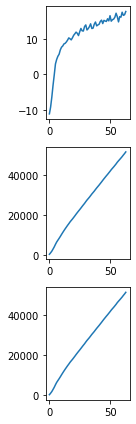

Train: accuracy 0.864, mean-loglik -0.293
Valid: accuracy 0.857, mean-loglik -0.308



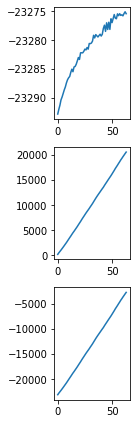

Train: accuracy 0.871, mean-loglik -0.278
Valid: accuracy 0.857, mean-loglik -0.310



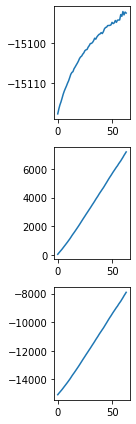

Train: accuracy 0.877, mean-loglik -0.266
Valid: accuracy 0.855, mean-loglik -0.315



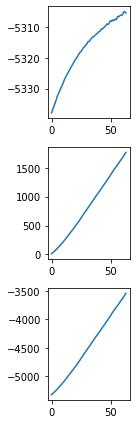

In [ ]:
print_valid_every = 1

while not server.should_stop():
    
    server.tick()
    
    train_acc, train_loglik = acc_and_ll(server, torch.tensor(x_train).float(), torch.tensor(y_train).float())
    valid_acc, valid_loglik = acc_and_ll(server, valid_set['x'], valid_set['y'])
     
    print(f'Train: accuracy {train_acc:.3f}, mean-loglik {train_loglik:.3f}\n'
          f'Valid: accuracy {valid_acc:.3f}, mean-loglik {valid_loglik:.3f}\n')
        
        
    plt.figure(figsize=(2 * num_clients, 6))

    for i in range(num_clients):

        plt.subplot(3, num_clients, i + 1)
        elbo = server.get_compiled_log()[f'client_{i}']['training_curves'][server.iterations-1]['elbo']
        plt.plot(elbo)
        
        plt.subplot(3, num_clients, num_clients + i + 1)
        kl = server.get_compiled_log()[f'client_{i}']['training_curves'][server.iterations-1]['kl']
        plt.plot(np.array(kl))
        
        plt.subplot(3, num_clients, 2 * num_clients + i + 1)
        ll = server.get_compiled_log()[f'client_{i}']['training_curves'][server.iterations-1]['ll']
        plt.plot(ll)

    plt.tight_layout()
    plt.show()

In [ ]:
mix = torch.distributions.Categorical(torch.rand(3, 5))
comp = torch.distributions.Categorical(logits=torch.randn(3, 5, 2))
gmm = torch.distributions.MixtureSameFamily(mix, comp)

gmm.mean

In [ ]:
dir(gmm)